In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [2]:
df = pd.read_csv('review_test.csv',encoding = 'unicode_escape')
df.head()

,listing_id,comments
0,292757,1 A location!
1,162809,1)Robbie is a gorgeous host with great hospita...
2,200979,A 5 star experience!
3,181823,A bliss! Just go and do it!!!
4,162809,A charming apartment. Rob was very hospitable ...


In [3]:
df2 = df.dropna(how="any")

In [4]:
df.count()

listing_id    199
comments      199
dtype: int64

In [5]:
df2['comments'] = df2['comments'].apply(lambda row: row.encode('ascii',errors='ignore').decode())

Uncomment # nltk.download('vader_lexicon') when running for the first time

In [6]:
### nltk and string transformations
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
import nltk
# nltk.download('vader_lexicon')

### numpy for seed.  
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

In [7]:
### Define simple space tokenizer
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(df2['comments'].head().apply(lambda x : simple_tokenizer(x)))

# Creates the polarity rating for the reviews
analyzer = SentimentIntensityAnalyzer()

df2['polarity']=df2['comments'].apply(lambda x : str(analyzer.polarity_scores(x)["compound"]))


0                                     [1, a, location]
1    [1robbie, is, a, gorgeous, host, with, great, ...
2                             [a, 5, star, experience]
3                    [a, bliss, just, go, and, do, it]
4    [a, charming, apartment, rob, was, very, hospi...
Name: comments, dtype: object


In [8]:
### Developing the corpus or list of sentences for processing later
corpus = df2['comments'].tolist()

print(corpus[:5])

['1 A location!', '1)Robbie is a gorgeous host with great hospitality! We arrived in Dublin late at night but we still cook dinner together. 2)Cozy environment and nice neighborhood! 3)Easy transportation where the bus station nearby:) \nWe all had a great time spending in Robbies place and Dublin:) thanks again', 'A 5 star experience!', 'A bliss! Just go and do it!!!', 'A charming apartment. Rob was very hospitable and provided a lovely breakfast.']


Creates the class column based on the polarity score

In [9]:
df2['class'] = df2['polarity'].astype(float).apply(lambda x : 'positive' if x > 0.500 else 'negative')

class_names = ['negative', 'positive']

Creates the polarity column of 1 or 0 (positive or negative) based on the polarity score

In [10]:
df2['polarity2'] = df2['polarity'].astype(float).apply(lambda x : 1 if x > 0.500 else 0)

In [11]:
df2.head()

,listing_id,comments,polarity,class,polarity2
0,292757,1 A location!,0.0,negative,0
1,162809,1)Robbie is a gorgeous host with great hospita...,0.963,positive,1
2,200979,A 5 star experience!,0.0,negative,0
3,181823,A bliss! Just go and do it!!!,0.7067,positive,1
4,162809,A charming apartment. Rob was very hospitable ...,0.6124,positive,1


Removing any new lines left in the corpus, before running the tokenizer

In [12]:
corpus1 = [x.replace('\n', '') for x in corpus]


We will now use the tokenizer within the TFIDF vectorizer.  The words might sound intimidating yet simply yet in reality basically we just counting the number of times a words occur within the sentence relative to the whole sample (sometimes called a corpus).

In [13]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus1)
X = tf.transform(corpus1)

### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), df2['polarity2']], axis=1)
print("Vector features : ", vectorizer.get_feature_names())
print("Vector shape/size : ",X.shape)

Vector features :  ['', '\tare', '\tstay', '\tthere', '\twe', '1', '10', '100', '1000', '1010', '1030pm', '1100pm', '12301pm', '1230am', '126', '12600', '12am', '133', '14', '15', '1530', '16', '18', '1robbie', '2', '2\tbad', '20', '2000', '2030', '24', '247', '24hour', '25', '2528', '25min', '275', '27a', '28', '291', '2cozy', '2nd', '3', '30', '3040', '32', '34', '35', '39', '3am', '3easy', '3pm', '3rd', '4', '4\thorrible', '40', '42', '45', '48', '4am', '4pm', '4th', '5', '5\t', '500', '57', '59', '5pm', '6', '60s', '6am', '6pm', '7', '7\tdirty', '7am', '7pm', '8', '8\tnoise', '80', '8pm', '9', 'able', 'absolutely', 'access', 'accessedother', 'accessible', 'accessory', 'accogliente', 'accoglienza', 'accommodating', 'accommodation', 'accommodations', 'accomodation', 'accordingly', 'accuracy', 'accurate', 'acknowledged', 'acrylic', 'acting', 'activate', 'actually', 'adam', 'addition', 'additional', 'address', 'addressed', 'addressed\tfalse', 'adequately', 'adorable', 'adults', 'advert

C:\Users\heath\Anaconda3\envs\base3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [14]:
target_col = 'polarity2'
y =df2[target_col]
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(target_col , axis=1),y, test_size=0.30, random_state=SEED)
print(X_train.shape, y_train.shape)

(139, 2271) (139,)


## Model Training and Analysis

**Helper Function**  : This is a simple helper function modified from the sklearn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).  Example below.  Parameters required are the actual labels (y_true), the predicted labels (y_pred), classes in a list like `["good", "bad", "ugly"]`.  Options are using `normalize` to get percentages, `include_cm` to print off the raw confusion matrix, and `fig_size` for the size of the plot.

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Using a Multinomial Naive Bayes Model

In [16]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
confusion_matrix(y_test, y_pred)

array([[16, 10],
       [ 1, 33]], dtype=int64)

In [18]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 81.67 %


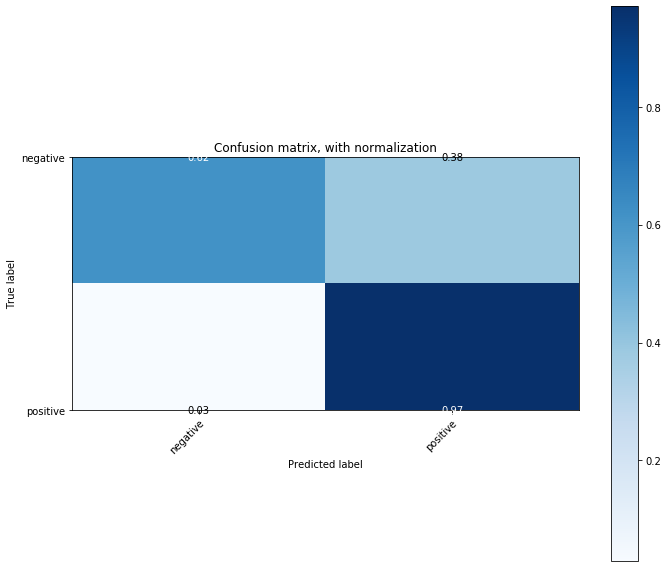

In [19]:
### Plot confusion matrix to get a feel for model ability to predict correct label.
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

Using a Random Forest model.

In [20]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=SEED).fit(X_train, y_train)
y_pred = clf2.predict(X_test)

In [21]:
confusion_matrix(y_test, y_pred)

array([[12, 14],
       [ 0, 34]], dtype=int64)

In [22]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 76.67 %


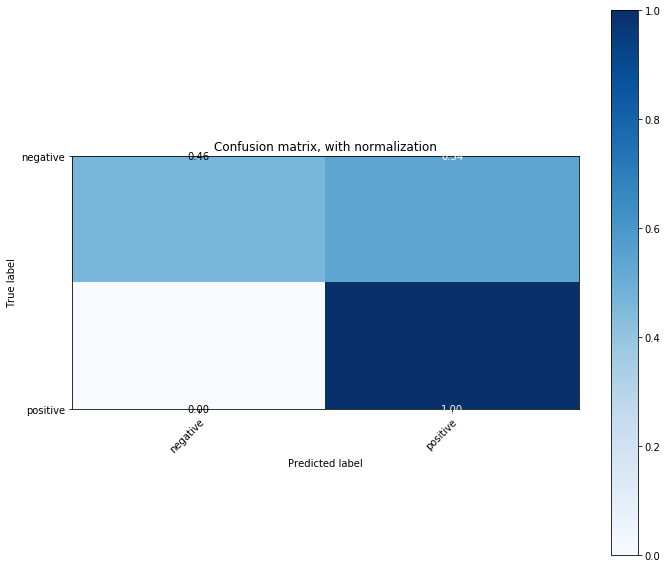

In [23]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

## Single Input Examples

For this data saet, the Random Forest is unable to give a negative results since in the data sample given it there were no negative results. The multinomialNB is the better of the two models.

In [24]:
review = "Best tacos I have ever had, will come back every Tuesday.  Will never go to any other taco shop again."

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))


Review was positive


Using Random Forest Model

In [25]:
review = "Horrible, worst food, service poor"

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf2.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))

Review was positive


Using NaiveBayes Model

In [26]:
review = "Horrible, worst food, service poor"

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))

Review was negative


##  Comparing Multiple Models Side by Side

Example found [here](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f).  Interesting final reference.

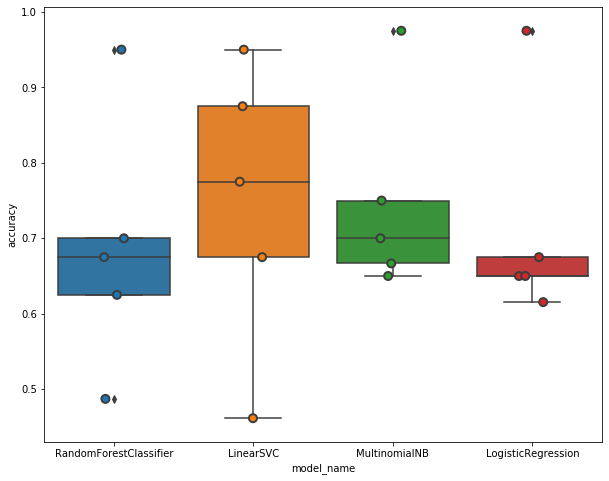

In [27]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

### Gather all features (X values) and labels (y values) to pass through cross validation
features = full_df.drop(target_col, axis=1)
labels = df2[target_col].values

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

<!-- Pie chart of positive negative reviews -->

Pie Chart of Test Date Reviews

In [28]:
count_review = df2["class"].value_counts()

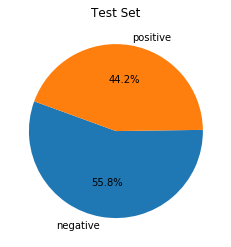

In [29]:
plt.pie(count_review, labels=class_names, autopct="%1.1f%%", startangle=160)
plt.title("Test Set")
plt.show()